#### Final part of the project - using the top six ranked climatic params to predict bird hotspot intensity at a tract-level for the next six days (after july 15th).


In [427]:
import pandas as pd
import geopandas as gpd
from pathlib import Path
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from PIL import Image
import imageio.v2 as imageio
import datetime
import zipfile
import shutil

#### data prep

In [428]:
shap = pd.read_csv("all_days_shap_finished.csv")
# drop surface pressure and precipitation -> two lowest least-impactful params
shap = shap.rename(columns={"Unnamed: 0":"Day"})
shap = shap.drop(columns=['surface_pressure','precipitation'],axis=1)
print(f"top 6 most impactful features (according to shap ranking):\n{list(shap.columns[1:])}")

top 6 most impactful features (according to shap ranking):
['temperature_180m', 'wind_direction_180m', 'wind_speed_180m', 'cloud_cover', 'relative_humidity_2m', 'visibility']


In [429]:
intensity = pd.read_csv("Chicago_CT_Point.csv")
intensity.head()

,TRACTCE10,GEOID10,NAME10,NAMELSAD10,Long,Lat,GEOID_Matc,State,County,Community,...,06_JLY,07_JLY,08_JLY,09_JLY,10_JLY,11_JLY,12_JLY,13_JLY,14_JLY,15_JLY
0,10100.0,1.703101e+10,101.00,Census Tract 101,-87.669844,42.021262,1.703101e+10,ILLINOIS,Cook,1.0,...,2.08279,0.030678,0.733111,0.196165,1.005510,1.92015,0.852281,1.44613,-1.62697,0.957384
1,10201.0,1.703101e+10,102.01,Census Tract 102.01,-87.680149,42.016008,1.703101e+10,ILLINOIS,Cook,1.0,...,2.12943,-0.356848,0.721191,0.187405,0.796464,1.91168,0.840111,1.46105,-1.61553,0.985709
2,10202.0,1.703101e+10,102.02,Census Tract 102.02,-87.673322,42.016050,1.703101e+10,ILLINOIS,Cook,1.0,...,2.21761,-0.069992,0.735649,0.214665,0.905013,1.90990,0.848700,1.47602,-1.55933,0.959192
3,10300.0,1.703101e+10,103.00,Census Tract 103,-87.666535,42.015941,1.703101e+10,ILLINOIS,Cook,1.0,...,2.20066,0.142566,0.746841,0.244895,0.855881,1.91138,0.857554,1.46493,-1.64321,0.938424
4,10400.0,1.703101e+10,104.00,Census Tract 104,-87.657167,42.005440,1.703101e+10,ILLINOIS,Cook,1.0,...,2.19104,0.586577,0.805455,0.269934,0.491964,1.89636,0.879911,1.49512,-1.77987,0.899077


In [430]:
# THIS UPDATED WEATHER CSV CONTAINS DATA FROM 06-15 to 07-21 (end of prediction)

past_weather = pd.read_csv("per-census-agg-weather-data.csv")
six_day_weather = pd.read_csv("six-day-per-census-agg-weather-data.csv")

weather = pd.concat([past_weather, six_day_weather]) #combiningi vertically
weather.shape

(29637, 21)

In [431]:
merged = pd.merge(intensity, weather, left_on="NAMELSAD10",right_on="namelsad10", how="inner")
merged["NAMELSAD10"].nunique()

798

In [432]:
merged.columns

Index(['TRACTCE10', 'GEOID10', 'NAME10', 'NAMELSAD10', 'Long', 'Lat',
       'GEOID_Matc', 'State', 'County', 'Community', 'Communit_1', '15_JUN',
       '16_JUN', '17_JUN', '18_JUN', '19_JUN', '20_JUN', '21_JUN', '22_JUN',
       '23_JUN', '24_JUN', '25_JUN', '26_JUN', '27_JUN', '28_JUN', '29_JUN',
       '30_JUN', '01_JLY', '02_JLY', '03_JLY', '04_JLY', '05_JLY', '06_JLY',
       '07_JLY', '08_JLY', '09_JLY', '10_JLY', '11_JLY', '12_JLY', '13_JLY',
       '14_JLY', '15_JLY', 'cleaned_time', 'tract_id', 'temperature_180m',
       'wind_direction_180m', 'wind_speed_180m', 'surface_pressure',
       'cloud_cover', 'relative_humidity_2m', 'precipitation', 'visibility',
       'statefp10', 'countyfp10', 'tractce10', 'name10', 'namelsad10',
       'commarea', 'commarea_n', 'notes', 'geometry', 'latitude', 'longitude'],
      dtype='object')

In [433]:
# this will ultimately define the features matrices but I need to drop a lot of columns
cols_to_keep = ['TRACTCE10','tract_id','cleaned_time','temperature_180m', 'wind_direction_180m', 'wind_speed_180m', 'cloud_cover', 'relative_humidity_2m', 'visibility','15_JUN',
       '16_JUN', '17_JUN', '18_JUN', '19_JUN', '20_JUN', '21_JUN', '22_JUN',
       '23_JUN', '24_JUN', '25_JUN', '26_JUN', '27_JUN', '28_JUN', '29_JUN',
       '30_JUN', '01_JLY', '02_JLY', '03_JLY', '04_JLY', '05_JLY', '06_JLY',
       '07_JLY', '08_JLY', '09_JLY', '10_JLY', '11_JLY', '12_JLY', '13_JLY',
       '14_JLY', '15_JLY']

getis_scores=['15_JUN',
       '16_JUN', '17_JUN', '18_JUN', '19_JUN', '20_JUN', '21_JUN', '22_JUN',
       '23_JUN', '24_JUN', '25_JUN', '26_JUN', '27_JUN', '28_JUN', '29_JUN',
       '30_JUN', '01_JLY', '02_JLY', '03_JLY', '04_JLY', '05_JLY', '06_JLY',
       '07_JLY', '08_JLY', '09_JLY', '10_JLY', '11_JLY', '12_JLY', '13_JLY',
       '14_JLY', '15_JLY']

In [434]:
## IMPORTANT STEP ###
# my merged df currrently has z-score values for dates greater than 7/15 which is misleading
# fix -> if date > 7/15 -> merged[col] = NaN 

filter_date = pd.to_datetime("2025-07-15")
merged["cleaned_time"] = pd.to_datetime(merged["cleaned_time"])

for col in getis_scores:
    merged.loc[merged["cleaned_time"] > filter_date, col] = np.nan

merged = merged[cols_to_keep]

In [435]:
merged.columns

Index(['TRACTCE10', 'tract_id', 'cleaned_time', 'temperature_180m',
       'wind_direction_180m', 'wind_speed_180m', 'cloud_cover',
       'relative_humidity_2m', 'visibility', '15_JUN', '16_JUN', '17_JUN',
       '18_JUN', '19_JUN', '20_JUN', '21_JUN', '22_JUN', '23_JUN', '24_JUN',
       '25_JUN', '26_JUN', '27_JUN', '28_JUN', '29_JUN', '30_JUN', '01_JLY',
       '02_JLY', '03_JLY', '04_JLY', '05_JLY', '06_JLY', '07_JLY', '08_JLY',
       '09_JLY', '10_JLY', '11_JLY', '12_JLY', '13_JLY', '14_JLY', '15_JLY'],
      dtype='object')

In [436]:
# finally, I need the geometry column from chicago_tracts to then plot the prediction
chicago_tracts = gpd.read_file("Chicago_Tracts_2010.zip")

## important: combining  ##
chicago_tracts.loc[chicago_tracts["tractce10"] == "980000", "tractce10"] = "760802"
chicago_tracts.loc[chicago_tracts["tractce10"] == "770602", "tractce10"] = "760801"
###########

print(f"chicago tracts: {chicago_tracts.dtypes}")
print(f"\nmerged: {merged.dtypes}")

chicago tracts: statefp10       object
countyfp10      object
tractce10       object
geoid10         object
name10          object
namelsad10      object
commarea        object
commarea_n     float64
notes           object
geometry      geometry
dtype: object

merged: TRACTCE10                      float64
tract_id                         int64
cleaned_time            datetime64[ns]
temperature_180m               float64
wind_direction_180m            float64
wind_speed_180m                float64
cloud_cover                    float64
relative_humidity_2m           float64
visibility                     float64
15_JUN                         float64
16_JUN                         float64
17_JUN                         float64
18_JUN                         float64
19_JUN                         float64
20_JUN                         float64
21_JUN                         float64
22_JUN                         float64
23_JUN                         float64
24_JUN                       

In [437]:
chicago_tracts["geoid10"] = pd.to_numeric(chicago_tracts["geoid10"])

In [438]:
chicago_tracts["tractce10"] = pd.to_numeric(chicago_tracts["tractce10"])

In [439]:
master_data = pd.merge(merged, chicago_tracts, left_on="TRACTCE10", right_on="tractce10", how="inner")

<Axes: >

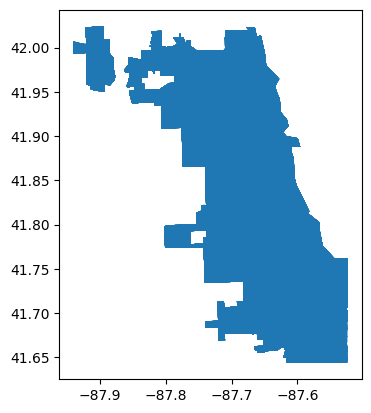

In [440]:
master_data = gpd.GeoDataFrame(master_data, geometry="geometry", crs="EPSG:4326")
master_data[["geometry"]].plot()

In [441]:
cols_to_keep.append("geometry")
print(cols_to_keep)

['TRACTCE10', 'tract_id', 'cleaned_time', 'temperature_180m', 'wind_direction_180m', 'wind_speed_180m', 'cloud_cover', 'relative_humidity_2m', 'visibility', '15_JUN', '16_JUN', '17_JUN', '18_JUN', '19_JUN', '20_JUN', '21_JUN', '22_JUN', '23_JUN', '24_JUN', '25_JUN', '26_JUN', '27_JUN', '28_JUN', '29_JUN', '30_JUN', '01_JLY', '02_JLY', '03_JLY', '04_JLY', '05_JLY', '06_JLY', '07_JLY', '08_JLY', '09_JLY', '10_JLY', '11_JLY', '12_JLY', '13_JLY', '14_JLY', '15_JLY', 'geometry']


In [442]:
master_data = master_data[cols_to_keep]
master_data.dtypes

TRACTCE10                      float64
tract_id                         int64
cleaned_time            datetime64[ns]
temperature_180m               float64
wind_direction_180m            float64
wind_speed_180m                float64
cloud_cover                    float64
relative_humidity_2m           float64
visibility                     float64
15_JUN                         float64
16_JUN                         float64
17_JUN                         float64
18_JUN                         float64
19_JUN                         float64
20_JUN                         float64
21_JUN                         float64
22_JUN                         float64
23_JUN                         float64
24_JUN                         float64
25_JUN                         float64
26_JUN                         float64
27_JUN                         float64
28_JUN                         float64
29_JUN                         float64
30_JUN                         float64
01_JLY                   

<hr></hr>

In [443]:
features = ['temperature_180m', 'wind_direction_180m', 'wind_speed_180m', 'cloud_cover', 'relative_humidity_2m', 'visibility']

forecast_days = ['16_JLY', '17_JLY', '18_JLY', '19_JLY', '20_JLY', '21_JLY']

In [444]:
past_weather.shape # this should match up with clean_master_data.shape 

(24831, 21)

In [445]:
clean_master_data = master_data[master_data[getis_scores].notna().all(axis=1)].reset_index(drop=True)
clean_master_data.shape # this excludes any days that have a getis_score of NaN

(24955, 41)

<Axes: >

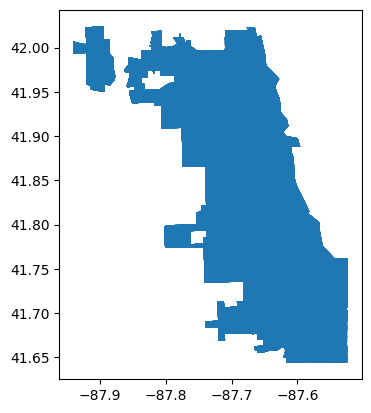

In [446]:
clean_master_data = gpd.GeoDataFrame(clean_master_data, geometry="geometry", crs="EPSG:4326")
clean_master_data[["geometry"]].plot()

In [447]:
def convert_target_to_date(target_str):
    """
    Converts a string like '16_JLY' to a datetime.date object.
    """
    day_str, month_code = target_str.split('_')
    day = int(day_str)

    month_map = {'JLY': 7}

    month = month_map[month_code]
    return datetime.date(2025, month, day)

print (convert_target_to_date("16_JLY"))

2025-07-16


#### version 1 - using all 31 day targets to train model

In [448]:
#### JUST INCASE, MELTING INTO LONG FORMAT TO GET TRAIN DATA FROM PAST 31 DAY TARGETS

train_rows = []
for zcol in getis_scores:
    temp = master_data.copy()
    temp['target_day'] = zcol
    temp['z_score'] = master_data[zcol]
    
    # only keep rows where z_score is not NaN
    temp = temp[~temp['z_score'].isna()]
    
    train_rows.append(temp[['tract_id', 'cleaned_time'] + features + ['z_score', 'target_day']])

train_df = pd.concat(train_rows, ignore_index=True)
train_df.shape

##### SIMPLY COMMENT THIS OUT IF NOT NEEDED ANYMORE #####

(773605, 10)

In [449]:
### TRAINING THE MODELX_train = train_df[features]
X_train = train_df[features]
y_train = train_df['z_score']

model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=30)
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=30)

In [450]:
# the loop training the random forest regressor for each forecast day (6 total)

master_data = master_data.copy() # prevent warning

for target in forecast_days:
    print("forecasting for {target}.")
    forecast_date = pd.to_datetime(convert_target_to_date(target))
    test_data = master_data[master_data['cleaned_time'] == forecast_date]

    X_test = test_data[features]
    preds = model.predict(X_test)

    master_data.loc[test_data.index, f"{target}_PRED"] = preds
    
    print(f"\nFinished. Appended pred value to master_data.")

forecasting for {target}.

Finished. Appended pred value to master_data.
forecasting for {target}.

Finished. Appended pred value to master_data.
forecasting for {target}.

Finished. Appended pred value to master_data.
forecasting for {target}.

Finished. Appended pred value to master_data.
forecasting for {target}.

Finished. Appended pred value to master_data.
forecasting for {target}.

Finished. Appended pred value to master_data.


In [451]:
forecast_dates = pd.date_range('2025-07-16', '2025-07-21')
forecast_only = master_data[master_data['cleaned_time'].isin(forecast_dates)]

#### version 2 - training on one target/mean of other target days

In [452]:
for target in forecast_days:
    print(f"training for {target}...")

    train_target = "15_JLY"

    X_train = clean_master_data[features]
    y_train = clean_master_data[train_target]

    model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=30)
    model.fit(X_train, y_train)

    test_data = master_data[master_data['cleaned_time'] == pd.to_datetime(convert_target_to_date(target))]
    print(f"\nFound {len(test_data)} rows for date {convert_target_to_date(target)}")

    X_test = test_data[features]
    preds = model.predict(X_test)

    master_data.loc[test_data.index, f"{target}_PRED"] = preds
    print(f"\nFinished. Appended pred value to master_data.")
    print(f"{len(test_data)} tract data generated for {target}\n")

training for 16_JLY...

Found 805 rows for date 2025-07-16

Finished. Appended pred value to master_data.
805 tract data generated for 16_JLY

training for 17_JLY...

Found 805 rows for date 2025-07-17

Finished. Appended pred value to master_data.
805 tract data generated for 17_JLY

training for 18_JLY...

Found 805 rows for date 2025-07-18

Finished. Appended pred value to master_data.
805 tract data generated for 18_JLY

training for 19_JLY...

Found 805 rows for date 2025-07-19

Finished. Appended pred value to master_data.
805 tract data generated for 19_JLY

training for 20_JLY...

Found 805 rows for date 2025-07-20

Finished. Appended pred value to master_data.
805 tract data generated for 20_JLY

training for 21_JLY...

Found 805 rows for date 2025-07-21

Finished. Appended pred value to master_data.
805 tract data generated for 21_JLY



In [453]:
forecast_dates = pd.date_range('2025-07-16', '2025-07-21')
forecast_only = master_data[master_data['cleaned_time'].isin(forecast_dates)]
forecast_only

,TRACTCE10,tract_id,cleaned_time,temperature_180m,wind_direction_180m,wind_speed_180m,cloud_cover,relative_humidity_2m,visibility,15_JUN,...,13_JLY,14_JLY,15_JLY,geometry,16_JLY_PRED,17_JLY_PRED,18_JLY_PRED,19_JLY_PRED,20_JLY_PRED,21_JLY_PRED
31,10100.0,17031010100,2025-07-16,76.458333,230.958333,17.570833,66.041667,81.583333,57264.326792,NaN,...,NaN,NaN,NaN,"POLYGON ((-87.66368 42.0194, -87.66384 42.0193...",0.093813,NaN,NaN,NaN,NaN,NaN
32,10100.0,17031010100,2025-07-17,63.812500,165.333333,12.437500,93.208333,84.083333,53614.392375,NaN,...,NaN,NaN,NaN,"POLYGON ((-87.66368 42.0194, -87.66384 42.0193...",NaN,0.294817,NaN,NaN,NaN,NaN
33,10100.0,17031010100,2025-07-18,66.158333,80.416667,6.650000,38.250000,79.958333,58562.992208,NaN,...,NaN,NaN,NaN,"POLYGON ((-87.66368 42.0194, -87.66384 42.0193...",NaN,NaN,0.308199,NaN,NaN,NaN
34,10100.0,17031010100,2025-07-19,73.604167,223.708333,14.283333,58.208333,87.291667,50347.222875,NaN,...,NaN,NaN,NaN,"POLYGON ((-87.66368 42.0194, -87.66384 42.0193...",NaN,NaN,NaN,0.582671,NaN,NaN
35,10100.0,17031010100,2025-07-20,69.533333,111.500000,11.508333,57.708333,89.083333,47298.775417,NaN,...,NaN,NaN,NaN,"POLYGON ((-87.66368 42.0194, -87.66384 42.0193...",NaN,NaN,NaN,NaN,0.260152,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29780,810400.0,17031810400,2025-07-17,62.450000,182.166667,12.575000,91.958333,82.791667,55883.639625,NaN,...,NaN,NaN,NaN,"POLYGON ((-87.83658 41.97976, -87.83658 41.979...",NaN,0.296803,NaN,NaN,NaN,NaN
29781,810400.0,17031810400,2025-07-18,65.787500,110.708333,7.125000,41.458333,76.583333,65589.457625,NaN,...,NaN,NaN,NaN,"POLYGON ((-87.83658 41.97976, -87.83658 41.979...",NaN,NaN,0.291042,NaN,NaN,NaN
29782,810400.0,17031810400,2025-07-19,73.087500,226.625000,14.950000,78.000000,81.041667,60053.040667,NaN,...,NaN,NaN,NaN,"POLYGON ((-87.83658 41.97976, -87.83658 41.979...",NaN,NaN,NaN,0.321897,NaN,NaN
29783,810400.0,17031810400,2025-07-20,69.037500,105.166667,12.162500,62.125000,87.125000,50688.976125,NaN,...,NaN,NaN,NaN,"POLYGON ((-87.83658 41.97976, -87.83658 41.979...",NaN,NaN,NaN,NaN,0.350748,NaN


In [454]:
# this is for when I have the six day z_score cols (repeat reshaping process from earlier)
# grnd_truth_zscore_long = 

# test_data = grnd_truth_zscore_long[(grnd_truth_zscore_long['cleaned_time'] >= '2025-07-16') & (grnd_truth_zscore_long['cleaned_time'] <= '2025-07-21')]
# y_test = test_data['bird_hotspot_intensity']

# r2 = r2_score(y_test, y_pred)
# rmse = mean_squared_error(y_test, y_pred, squared=False)

#### Using the forecasted bird hotspot intensity values for each tract -> generate tract-level gif: 

currently the way forecast only is structured, I will have problems plotting due to Nan for some tracts.

In [455]:
forecast_only.head() 

,TRACTCE10,tract_id,cleaned_time,temperature_180m,wind_direction_180m,wind_speed_180m,cloud_cover,relative_humidity_2m,visibility,15_JUN,...,13_JLY,14_JLY,15_JLY,geometry,16_JLY_PRED,17_JLY_PRED,18_JLY_PRED,19_JLY_PRED,20_JLY_PRED,21_JLY_PRED
31,10100.0,17031010100,2025-07-16,76.458333,230.958333,17.570833,66.041667,81.583333,57264.326792,NaN,...,NaN,NaN,NaN,"POLYGON ((-87.66368 42.0194, -87.66384 42.0193...",0.093813,NaN,NaN,NaN,NaN,NaN
32,10100.0,17031010100,2025-07-17,63.812500,165.333333,12.437500,93.208333,84.083333,53614.392375,NaN,...,NaN,NaN,NaN,"POLYGON ((-87.66368 42.0194, -87.66384 42.0193...",NaN,0.294817,NaN,NaN,NaN,NaN
33,10100.0,17031010100,2025-07-18,66.158333,80.416667,6.650000,38.250000,79.958333,58562.992208,NaN,...,NaN,NaN,NaN,"POLYGON ((-87.66368 42.0194, -87.66384 42.0193...",NaN,NaN,0.308199,NaN,NaN,NaN
34,10100.0,17031010100,2025-07-19,73.604167,223.708333,14.283333,58.208333,87.291667,50347.222875,NaN,...,NaN,NaN,NaN,"POLYGON ((-87.66368 42.0194, -87.66384 42.0193...",NaN,NaN,NaN,0.582671,NaN,NaN
35,10100.0,17031010100,2025-07-20,69.533333,111.500000,11.508333,57.708333,89.083333,47298.775417,NaN,...,NaN,NaN,NaN,"POLYGON ((-87.66368 42.0194, -87.66384 42.0193...",NaN,NaN,NaN,NaN,0.260152,NaN


In [456]:
forecast_only.columns

Index(['TRACTCE10', 'tract_id', 'cleaned_time', 'temperature_180m',
       'wind_direction_180m', 'wind_speed_180m', 'cloud_cover',
       'relative_humidity_2m', 'visibility', '15_JUN', '16_JUN', '17_JUN',
       '18_JUN', '19_JUN', '20_JUN', '21_JUN', '22_JUN', '23_JUN', '24_JUN',
       '25_JUN', '26_JUN', '27_JUN', '28_JUN', '29_JUN', '30_JUN', '01_JLY',
       '02_JLY', '03_JLY', '04_JLY', '05_JLY', '06_JLY', '07_JLY', '08_JLY',
       '09_JLY', '10_JLY', '11_JLY', '12_JLY', '13_JLY', '14_JLY', '15_JLY',
       'geometry', '16_JLY_PRED', '17_JLY_PRED', '18_JLY_PRED', '19_JLY_PRED',
       '20_JLY_PRED', '21_JLY_PRED'],
      dtype='object')

In [457]:
forecast_only[forecast_only["TRACTCE10"]==760802]["geometry"].nunique()

2

In [458]:
forecast_only[forecast_only["TRACTCE10"] == 760802]["geometry"].unique()

<GeometryArray>
[<POLYGON ((-87.858 41.958, -87.858 41.958, -87.858 41.958, -87.858 41.958, -...>, <POLYGON ((-87.921 42.005, -87.921 42.005, -87.921 42.005, -87.92 42.005, -8...>]
Length: 2, dtype: geometry

In [463]:
print(forecast_only[forecast_only["TRACTCE10"] == 760802]["geometry"].nunique())     # Should be 1
print(forecast_only[forecast_only["TRACTCE10"] == 760801]["geometry"].nunique())   # Should be 1

2
2


In [464]:
pred_cols = ['16_JLY_PRED', '17_JLY_PRED',
       '18_JLY_PRED', '19_JLY_PRED', '20_JLY_PRED', '21_JLY_PRED']

collapsed = forecast_only.groupby(["TRACTCE10", "geometry"]).agg(
    {col: "first" for col in pred_cols}
).reset_index()

collapsed

,TRACTCE10,geometry,16_JLY_PRED,17_JLY_PRED,18_JLY_PRED,19_JLY_PRED,20_JLY_PRED,21_JLY_PRED
0,10100.0,"POLYGON ((-87.66368 42.0194, -87.66384 42.0193...",0.093813,0.294817,0.308199,0.582671,0.260152,0.764140
1,10201.0,"POLYGON ((-87.6801 42.01254, -87.68027 42.0125...",0.472234,0.369037,0.475247,0.658709,0.193074,0.729192
2,10202.0,"POLYGON ((-87.67336 42.01937, -87.67311 42.019...",0.093813,0.294817,0.302675,0.577245,0.260152,0.764140
3,10300.0,"POLYGON ((-87.66506 42.0128, -87.66543 42.0127...",0.093813,0.294817,0.308199,0.582671,0.260152,0.764140
4,10400.0,"POLYGON ((-87.6508 41.99849, -87.655 41.99832,...",0.478963,0.296705,0.633930,0.532656,0.275703,0.739182
...,...,...,...,...,...,...,...,...
795,843500.0,"POLYGON ((-87.69279 41.84472, -87.6923 41.8447...",0.319393,0.288219,0.347246,0.057597,0.572613,0.483618
796,843600.0,"POLYGON ((-87.61129 41.80217, -87.61129 41.802...",0.327901,0.293127,0.173641,0.519681,0.314528,0.703307
797,843700.0,"POLYGON ((-87.69667 41.94854, -87.69673 41.948...",0.086844,0.292932,0.322125,0.778231,0.243199,0.760003
798,843800.0,"POLYGON ((-87.64516 41.7943, -87.64516 41.7944...",0.327901,0.293127,0.173641,0.519858,0.314528,0.703307


In [465]:
collapsed[collapsed["TRACTCE10"]==760802]

,TRACTCE10,geometry,16_JLY_PRED,17_JLY_PRED,18_JLY_PRED,19_JLY_PRED,20_JLY_PRED,21_JLY_PRED
683,760802.0,"POLYGON ((-87.92063 42.00453, -87.92056 42.004...",0.019051,0.356225,0.160299,-0.055757,0.273351,0.506778
684,760802.0,"POLYGON ((-87.85846 41.95793, -87.85833 41.958...",0.019051,0.356225,0.160299,-0.055757,0.273351,0.506778


In [466]:
collapsed = gpd.GeoDataFrame(collapsed, geometry='geometry', crs="EPSG:4326")

<Axes: >

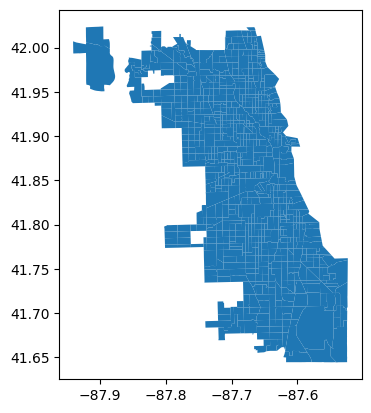

In [467]:
collapsed.plot()

#### SAVING COLLAPSED DF with all data to csv

In [488]:
collapsed.to_csv("six_day_forecast_intensity.csv")

#### predicted bird hotspot intensity gif generation

In [468]:
predicted_bird_intensity_frames = "pred_bird_intensity_frames"

In [471]:
os.makedirs(predicted_bird_intensity_frames, exist_ok=True)

for target in pred_cols: 
    fig, ax = plt.subplots(figsize=(8, 10)) 

    date = str(convert_target_to_date(target[:6]))

    collapsed.plot(
        column=target,
        ax=ax,
        cmap="RdPu",
        legend=False,
        linewidth=0.5,
        edgecolor="black"
    )

    vmin = collapsed[target].min()
    vmax = collapsed[target].max()

    # add a smaller colorbar manually
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = mpl.cm.ScalarMappable(cmap="RdPu", norm=norm)
    sm._A = []

    # create colorbar with fewer ticks
    cbar = fig.colorbar(
        sm,
        ax=ax,
        fraction=0.04,
        pad=0.02,
        aspect=20,
        shrink=0.4
    )
    cbar.set_label("Predicted Getis-Ord Gi* Intensity", fontsize=9)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_ticks([vmin, (vmin + vmax) / 2, vmax])

    ax.set_title(f"Predicted Migratory Birds Hot-Spot Intensity on {date}", fontsize=14)
    # plt.tight_layout()

    save_path = os.path.join(predicted_bird_intensity_frames, f"predicted_bird_intensity_{date}.png")

    plt.savefig(save_path, dpi=150)
    plt.close()

In [472]:
predicted_bird_intensity_gif_path = "predicted_bird_intensity.gif"

frames = [Image.open(os.path.join(predicted_bird_intensity_frames, f)) for f in os.listdir(predicted_bird_intensity_frames)]
frames[0].save(predicted_bird_intensity_gif_path, save_all=True, append_images=frames[1:], duration=850, loop=0)

#### creating the six forecast day shapefiles: 

In [473]:
# Ensure output directory exists
os.makedirs("forecast_zips", exist_ok=True)

# Your prediction columns/dates
forecast_days = ["16_JLY", "17_JLY", "18_JLY", "19_JLY", "20_JLY", "21_JLY"]

for day in forecast_days:
    date_str = f"2025-07-{int(day[:2]):02d}"  # Format to YYYY-MM-DD
    print(f"Processing {day} ({date_str})")

    # Filter data for that date
    day_data = forecast_only[forecast_only["cleaned_time"] == pd.to_datetime(date_str)].copy()

    if day_data.empty:
        print(f"⚠️ No data for {date_str}")
        continue

    # Only keep needed columns
    columns_to_keep = ["tract_id", "geometry", f"{day}_PRED"]
    gdf = gpd.GeoDataFrame(day_data[columns_to_keep], geometry="geometry", crs="EPSG:4326")

    # Folder for shapefile components
    shapefile_name = f"forecast_{day.lower()}"
    shapefile_dir = os.path.join("forecast_zips", shapefile_name)
    os.makedirs(shapefile_dir, exist_ok=True)

    # Write shapefile
    gdf.to_file(os.path.join(shapefile_dir, f"{shapefile_name}.shp"))

    # Create ZIP
    zip_path = f"{shapefile_dir}.zip"
    with zipfile.ZipFile(zip_path, "w") as zipf:
        for filename in os.listdir(shapefile_dir):
            filepath = os.path.join(shapefile_dir, filename)
            zipf.write(filepath, arcname=filename)  # only include filename, not full path

    # Remove the unzipped folder
    shutil.rmtree(shapefile_dir)

    print(f"✅ Created {zip_path}")



Processing 16_JLY (2025-07-16)
✅ Created forecast_zips\forecast_16_jly.zip
Processing 17_JLY (2025-07-17)


C:\Users\ITO\AppData\Local\Temp\ipykernel_22544\1487133783.py:28: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(os.path.join(shapefile_dir, f"{shapefile_name}.shp"))
c:\Users\ITO\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: '16_JLY_PRED' to '16_JLY_PRE'
  ogr_write(
C:\Users\ITO\AppData\Local\Temp\ipykernel_22544\1487133783.py:28: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(os.path.join(shapefile_dir, f"{shapefile_name}.shp"))
c:\Users\ITO\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: '17_JLY_PRED' to '17_JLY_PRE'
  ogr_write(


✅ Created forecast_zips\forecast_17_jly.zip
Processing 18_JLY (2025-07-18)
✅ Created forecast_zips\forecast_18_jly.zip
Processing 19_JLY (2025-07-19)


C:\Users\ITO\AppData\Local\Temp\ipykernel_22544\1487133783.py:28: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(os.path.join(shapefile_dir, f"{shapefile_name}.shp"))
c:\Users\ITO\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: '18_JLY_PRED' to '18_JLY_PRE'
  ogr_write(
C:\Users\ITO\AppData\Local\Temp\ipykernel_22544\1487133783.py:28: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(os.path.join(shapefile_dir, f"{shapefile_name}.shp"))
c:\Users\ITO\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: '19_JLY_PRED' to '19_JLY_PRE'
  ogr_write(


✅ Created forecast_zips\forecast_19_jly.zip
Processing 20_JLY (2025-07-20)
✅ Created forecast_zips\forecast_20_jly.zip
Processing 21_JLY (2025-07-21)
✅ Created forecast_zips\forecast_21_jly.zip


C:\Users\ITO\AppData\Local\Temp\ipykernel_22544\1487133783.py:28: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(os.path.join(shapefile_dir, f"{shapefile_name}.shp"))
c:\Users\ITO\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: '20_JLY_PRED' to '20_JLY_PRE'
  ogr_write(
C:\Users\ITO\AppData\Local\Temp\ipykernel_22544\1487133783.py:28: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(os.path.join(shapefile_dir, f"{shapefile_name}.shp"))
c:\Users\ITO\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: '21_JLY_PRED' to '21_JLY_PRE'
  ogr_write(


#### top 6 climatic parameter July 16th to July 21st Map GIF Generation
* excludes precipitation and surface pressure

In [55]:
six_day_weather = pd.read_csv("six-day-per-census-agg-weather-data.csv")
chicago_tracts = gpd.read_file("Chicago_Tracts_2010.zip")

# keep only cols of interest
six_day_weather = six_day_weather[['cleaned_time', 'tract_id', 
        'temperature_180m', 'wind_direction_180m',
       'wind_speed_180m', 'cloud_cover',
       'relative_humidity_2m', 'visibility', 'tractce10']]

In [56]:
six_day_weather["tractce10"] = pd.to_numeric(six_day_weather["tractce10"])
chicago_tracts["tractce10"] = pd.to_numeric(chicago_tracts["tractce10"])
six_day_weather = six_day_weather.rename(columns={"geometry":"weather_geometry"})

In [57]:
# (once again)
# since the pre-existing geometry col is giving problems I will 
# merge again to keep it consistent and get the working geometry col
weather_merged = pd.merge(six_day_weather, chicago_tracts, on="tractce10", how="inner")

In [58]:
weather_merged = gpd.GeoDataFrame(weather_merged, geometry="geometry", crs="EPSG:4326")

In [59]:
weather_labels = {
    'temperature_180m': 'Temperature',
    'wind_direction_180m': 'Wind Direction',
    'wind_speed_180m': 'Wind Speed',
    'cloud_cover': 'Cloud Cover',
    'relative_humidity_2m': 'Relative Humidity',
    'visibility': 'Visibility'
}

weather_vars = ['temperature_180m', 'wind_direction_180m',
       'wind_speed_180m', 'cloud_cover',
       'relative_humidity_2m', 'visibility']

feature_cmaps = {
    'temperature_180m': 'Reds',
    'wind_direction_180m': 'Oranges',
    'wind_speed_180m': 'Greens',
    'cloud_cover': 'Purples',
    'relative_humidity_2m': 'YlOrBr',
    'visibility': 'Greys'
}

In [60]:
weather_merged.dtypes

cleaned_time              object
tract_id                   int64
temperature_180m         float64
wind_direction_180m      float64
wind_speed_180m          float64
cloud_cover              float64
relative_humidity_2m     float64
visibility               float64
tractce10                  int64
statefp10                 object
countyfp10                object
geoid10                   object
name10                    object
namelsad10                object
commarea                  object
commarea_n               float64
notes                     object
geometry                geometry
dtype: object

In [62]:
new_path = "six_day_weather_gif_frames"
gif_destination = "six_day_weather_gifs"
os.makedirs(new_path, exist_ok=True)
os.makedirs(gif_destination, exist_ok=True)

for var in weather_vars:
    frames = []
    unique_days = sorted(weather_merged["cleaned_time"].unique())
    standard_size = None

    for day in unique_days:
        daily = weather_merged[weather_merged["cleaned_time"]==day]

        fig, ax = plt.subplots(figsize=(7, 7)) 

        daily.plot(
            column=var,
            ax=ax,
            cmap=feature_cmaps[var],
            legend=False,
            linewidth=0.5,
            edgecolor="black"
        )   

        vmin = daily[var].min() # local
        vmax = daily[var].max()

        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        sm = mpl.cm.ScalarMappable(cmap=feature_cmaps[var], norm=norm)
        sm._A = []

        bbox = ax.get_position()

        # adding a legend manually to stop the shifting b/c of varying decimals
        cax = fig.add_axes([
            bbox.x1 + 0.01,          # x-position (just to the right of the map)
            bbox.y0 + 0.25,          # y-position (start 25% from bottom)
            0.02,                    # width
            bbox.height * 0.5        # height (50% of map height)
        ])
        
        cbar = plt.colorbar(sm, cax=cax)

        cbar.set_label(f"{weather_labels[var]}", fontsize=9)
        cbar.ax.tick_params(labelsize=8)

        ax.set_title(f"{weather_labels[var]} on {day}", fontsize=14)

        ticks = [vmin, (vmin + vmax)/2, vmax]
        cbar.set_ticks(ticks)
        cbar.ax.set_yticklabels([f"{t:.2f}" for t in ticks])
        # fig.subplots_adjust(left=1, right=1, bottom=1, top=1)

        frame_path = f"{new_path}/{var}_on_{day}.png"

        plt.savefig(frame_path, bbox_inches=None, pad_inches=0)
        plt.close()
        
        img = imageio.imread(frame_path)
        
        if standard_size is None:
            standard_size = Image.fromarray(img).size
        img = Image.fromarray(img).resize(standard_size)
        frames.append(np.array(img))

    gif_path = f"{gif_destination}/{var}.gif"
    imageio.mimsave(gif_path, frames, duration=850, loop=0)

#### bird presence and hotspot intensity plotting (last 2 gifs needed)

In [474]:
chicago_boundary = gpd.read_file("Chicago_Tracts_2010.zip")
multipolygon = chicago_boundary.dissolve(by=None)

In [476]:
## making hotspot density maps for gif:
bird_presence_path = "./six_day_data"
hotspot_frames_path = "forecast_period_bird_presence"

os.makedirs(hotspot_frames_path, exist_ok=True)

for daily_data in os.listdir(bird_presence_path):
    full_path = os.path.join(bird_presence_path, daily_data)

    gdf = gpd.read_file(full_path)
    gdf["howMany"] = gdf["howMany"].fillna(1)
    gdf = gdf.loc[gdf.groupby('locId')['howMany'].idxmax()].reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(8, 10)) 

    vmin = gdf["howMany"].min()
    vmax = gdf["howMany"].max()
    
    gdf_plot = gdf.plot(
        column="howMany",
        ax=ax,
        cmap="coolwarm",
        legend=False
    )

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = mpl.cm.ScalarMappable(cmap="coolwarm", norm=norm)
    sm._A = []

    cbar = fig.colorbar(
        sm,
        ax=ax,
        fraction=0.04,
        pad=0.02,
        aspect=20,
        shrink=0.4
    )
    cbar.set_label("Bird Abundance", fontsize=9)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_ticks([vmin, round((vmin + vmax) / 2), vmax])

    multipolygon.boundary.plot(ax=ax, color='black')

    date = os.path.splitext(daily_data)[0][:10]
    plt.title(f"Migratory Birds Presence on {date}", fontsize=16)

    save_path = os.path.join(hotspot_frames_path, f"bird_hotspot_density_{date}.png")

    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.close()
## creating the gif with the generated frames: 
gif_path = "forecast_period_bird_presence_animation.gif"

frames = [Image.open(os.path.join(hotspot_frames_path, f)) for f in os.listdir(hotspot_frames_path)]
frames[0].save(gif_path, save_all=True, append_images=frames[1:], duration=850, loop=0)

#### top 10 tracts with highest predicted bird hotspot intensity / extra viz for presentation

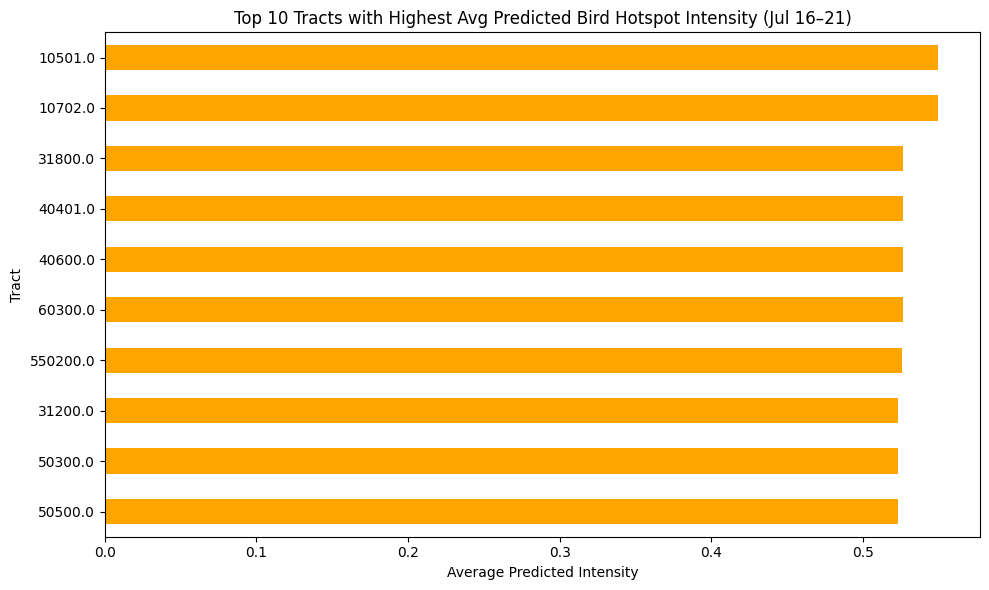

In [482]:
collapsed["mean_pred"] = collapsed[pred_cols].mean(axis=1)

top_10 = collapsed.nlargest(10, "mean_pred")

top_10.plot.barh(
    x="TRACTCE10", y="mean_pred", figsize=(10, 6), legend=False, color="orange"
)
plt.title("Top 10 Tracts with Highest Avg Predicted Bird Hotspot Intensity (Jul 16–21)")
plt.xlabel("Average Predicted Intensity")
plt.ylabel("Tract")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

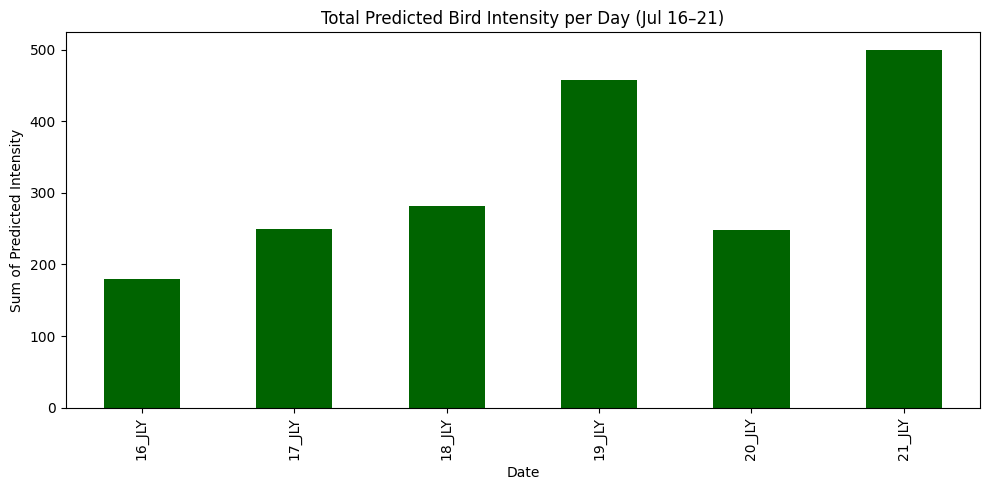

In [478]:
daily_totals = collapsed[pred_cols].sum().sort_index()

daily_totals.index = [col.replace("_PRED", "") for col in daily_totals.index]

daily_totals.plot.bar(
    figsize=(10, 5), color="darkgreen"
)
plt.title("Total Predicted Bird Intensity per Day (Jul 16–21)")
plt.xlabel("Date")
plt.ylabel("Sum of Predicted Intensity")
plt.tight_layout()
plt.show()


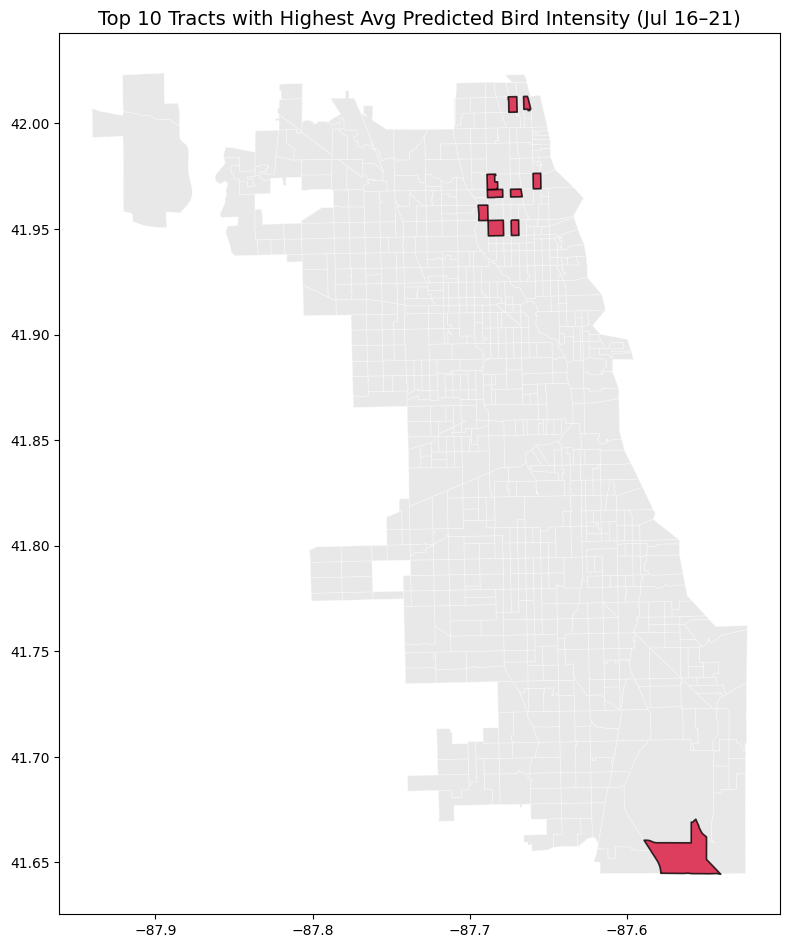

In [487]:
fig, ax = plt.subplots(figsize=(8, 10))

#all tracts 
collapsed.plot(
    ax=ax,
    color="lightgrey",
    edgecolor="white",
    linewidth=0.5,
    alpha=0.5,
)

top_10.plot(
    ax=ax,
    color="crimson",
    edgecolor="black",
    linewidth=1.2,
    alpha=0.8,
)

ax.set_title("Top 10 Tracts with Highest Avg Predicted Bird Intensity (Jul 16–21)", fontsize=14)

plt.tight_layout()
plt.show()
